In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from hyperopt import hp, tpe, fmin, Trials
from tqdm import tqdm

import datetime
import copy
import json

import sys
sys.path.append('../../')

from data.dataloader import Covid19IndiaLoader
from data.processing import get_data
from data.processing import granular, processing

from models.seir import SEIR_Testing, SEIRHD, SEIR_Movement, SEIR_Movement_Testing, SEIRHD_Severity, SEIRHD_Bed

from main.seir.fitting import single_fitting_cycle, get_variable_param_ranges
from main.seir.forecast import get_forecast, create_region_csv, create_all_csvs, write_csv
from utils.create_report import create_report
from utils.loss import Loss_Calculator
from utils.smooth_jump import smooth_big_jump_stratified, smooth_big_jump
from viz import plot_forecast

## Load Covid19india Data

In [3]:
loader = Covid19IndiaLoader()
dataframes = loader.get_covid19india_api_data()

In [4]:
predictions_dict = {}

## Select Districts to fit on

In [5]:
districts_to_show = [('Maharashtra', 'Mumbai')]

## Get Variable Params

In [6]:
variable_param_ranges = {
    'lockdown_R0': (1, 1.5),
    'T_inc': (4, 5),
    'T_inf': (3, 4),
    'T_recov_hq': (50, 70),
    'T_recov_non_oxy': (20, 30),
    'T_recov_oxy': (35, 50),
    'T_recov_icu': (50, 60),
    'T_recov_vent': (50, 60),
    'P_non_oxy': (0, 0.15),
    'P_oxy': (0, 0.15),
    'P_icu': (0, 0.05),
    'P_vent': (0, 0.05),
    'P_fatal': (0, 0.2),
    'E_hosp_ratio': (0, 2),
    'I_hosp_ratio': (0, 1)
}
variable_param_ranges = get_variable_param_ranges(variable_param_ranges)

## Assign Filename var

In [7]:
filename = '../../data/data/mumbai/case_summary_expanded_2006.csv'

## Perform M1 and M2 fits

Performing m1 fit ..
6191
smoothing length truncated to 33
3139
smoothing length truncated to 17
-891
smoothing length truncated to 18
917
smoothing length truncated to 65


/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


True
2835.65354425861
smoothing length truncated to 18
-943.1154018189955
smoothing length truncated to 23
237.32264797972266
smoothing length truncated to 23
273.0
smoothing length truncated to 23
377.0
smoothing length truncated to 8
-295.0
smoothing length truncated to 16
648.0
smoothing length truncated to 22
1746.0
smoothing length truncated to 23
1502.0
smoothing length truncated to 5
2009.0
smoothing length truncated to 8
796.0
smoothing length truncated to 22
865.0
smoothing length truncated to 27
770.483658203324
smoothing length truncated to 17
1280.0
smoothing length truncated to 25
760.0
smoothing length truncated to 25
868.0
smoothing length truncated to 22
849.0
smoothing length truncated to 22
217.0
smoothing length truncated to 23
415.0
smoothing length truncated to 17
splitting data ..
splitting data ..
train
          date        state district  total_infected  hospitalised  recovered  \
15 2020-06-09  Maharashtra   Mumbai         51864.6       23939.6    25424.2   
1

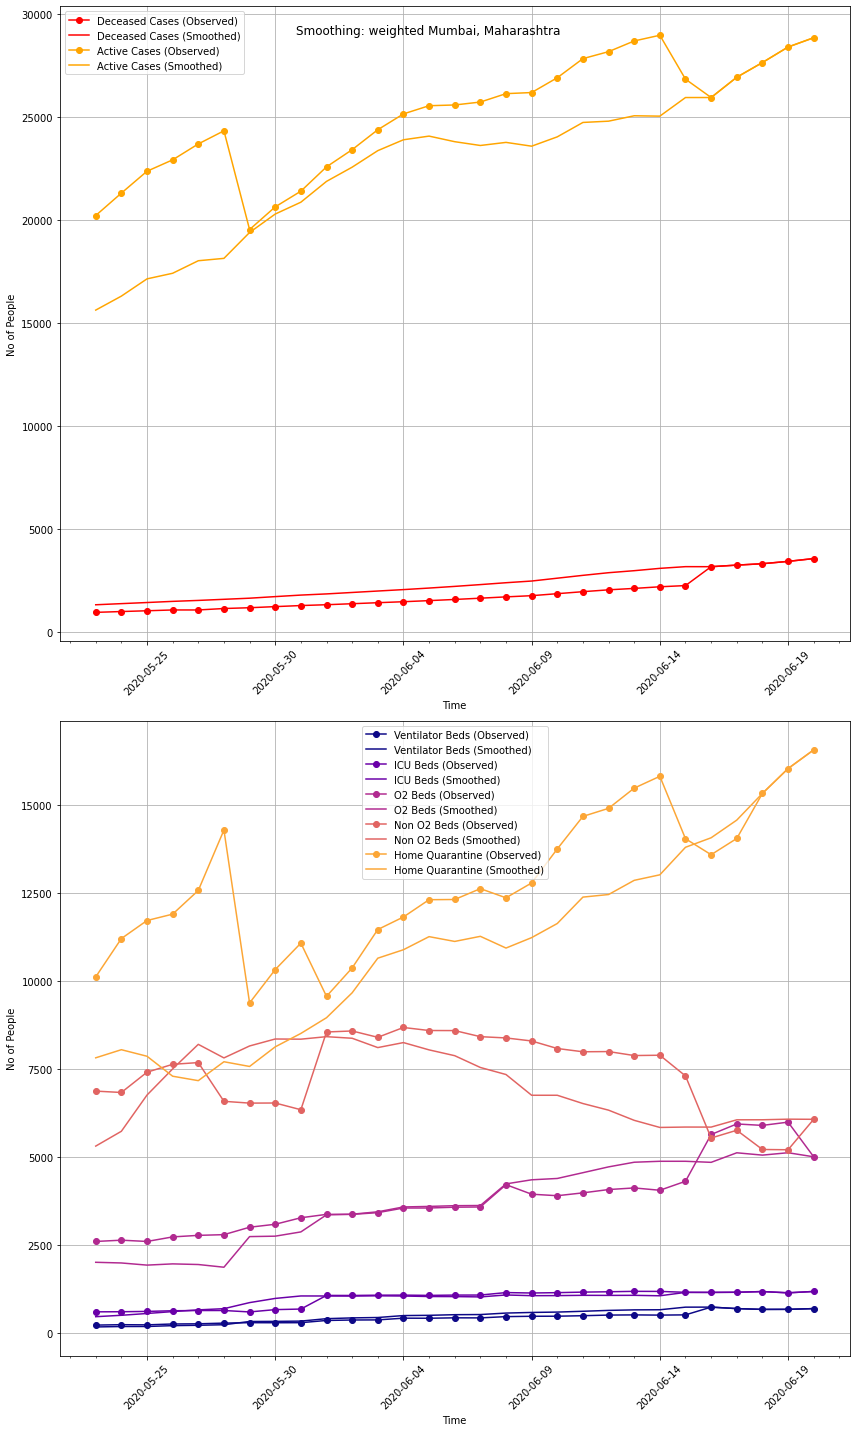

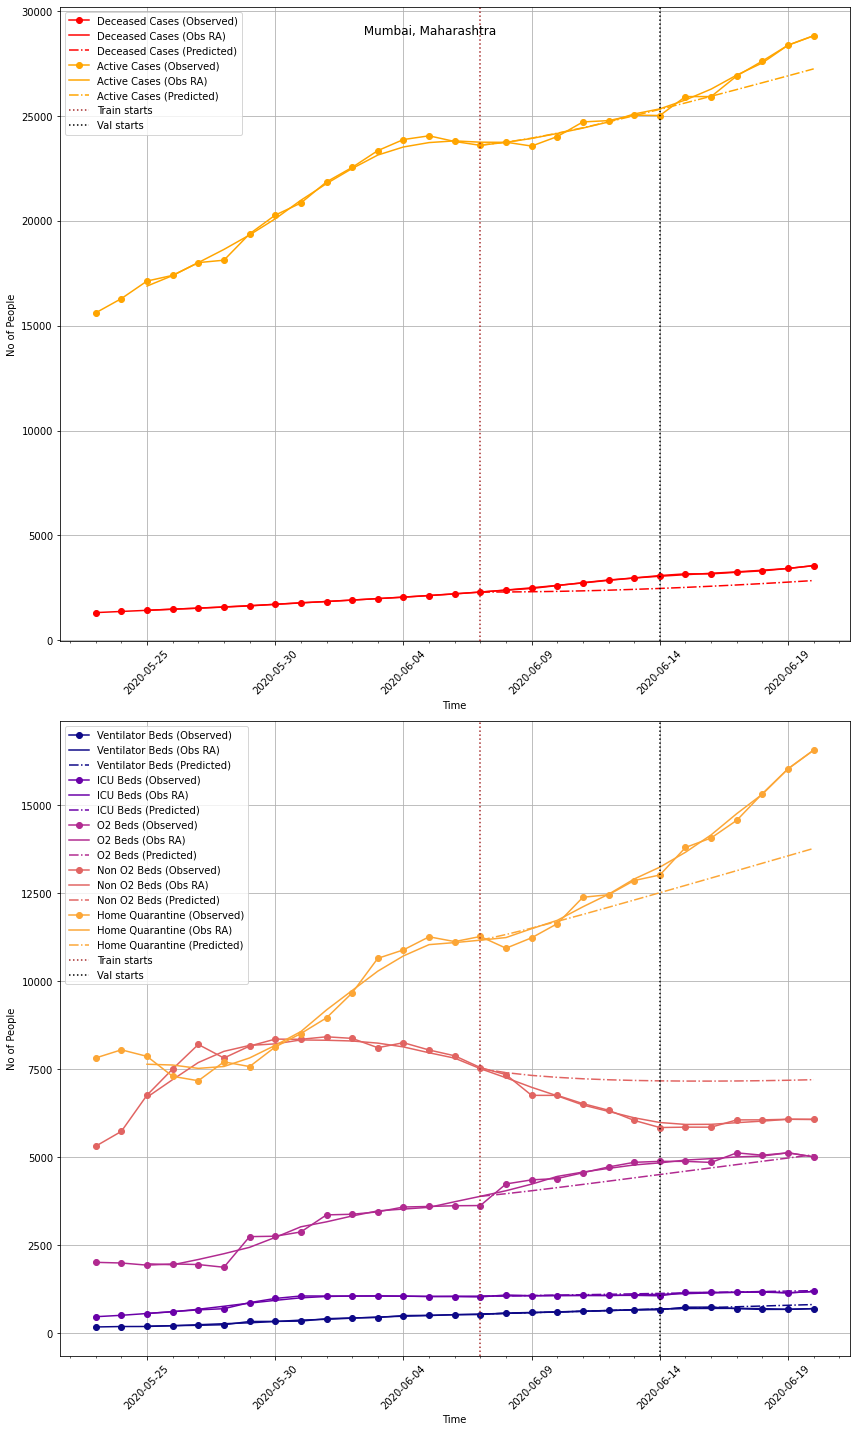

In [11]:
for state, district in districts_to_show:
    predictions_dict[(state, district)] = {}
    predictions_dict[(state, district)]['m1'] = single_fitting_cycle(
        dataframes, state, district, data_from_tracker=False, granular_data=True, filename=filename, #Data
        model=SEIRHD_Bed, variable_param_ranges=variable_param_ranges, #Choose Model and Ranges
        train_period=7, val_period=7, num_evals=1000, initialisation='intermediate', #Optimisation related parameters
        which_compartments=['hospitalised', 'deceased', 'hq', 'non_o2_beds', 'o2_beds', 'icu', 'ventilator'], #Compartments to Apply Loss on 
        smooth_jump=True, smoothing_length=33, smoothing_method='weighted') #Smoothing
    
    predictions_dict[(state, district)]['state'] = state
    predictions_dict[(state, district)]['dist'] = district
    predictions_dict[(state, district)]['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")
    predictions_dict[(state, district)]['datasource'] = 'covid19api' if predictions_dict[(state, district)]['m1']['data_from_tracker'] else 'municipality'
    predictions_dict[(state, district)]['variable_param_ranges'] = predictions_dict[(state, district)]['m1']['variable_param_ranges']
#     predictions_dict[(state, district)]['data_last_date'] = predictions_dict[(state, district)]['m2']['data_last_date']

In [12]:
predictions_dict[('Maharashtra', 'Mumbai')]['m1']['df_loss']

,train,val
hospitalised,0.542149,2.85432
deceased,11.6923,23.9065
hq,2.69226,12.2097
non_o2_beds,7.6536,16.723
o2_beds,7.8198,4.62382
icu,2.07065,2.06017
ventilator,1.03916,8.19673


In [13]:
predictions_dict[('Maharashtra', 'Mumbai')]['m1']['best_params']

{'E_hosp_ratio': 0.26242540582938717,
 'I_hosp_ratio': 0.14548180997798466,
 'P_fatal': 0.10137728108432353,
 'P_icu': 1.6507632336213145e-05,
 'P_non_oxy': 0.017728362829794033,
 'P_oxy': 0.1498101646760855,
 'P_vent': 0.026658860509065116,
 'T_inc': 4.568293744541404,
 'T_inf': 3.4353661189747187,
 'T_recov_hq': 63.454554800784784,
 'T_recov_icu': 52.137556896301646,
 'T_recov_non_oxy': 24.649003016623418,
 'T_recov_oxy': 47.78247621415769,
 'T_recov_vent': 56.58609801003307,
 'lockdown_R0': 1.078263120028951}

## Gridsearch + Bayesian Opt

In [18]:
default_params = predictions_dict[('Maharashtra', 'Mumbai')]['m1']['best_params']
train_period = 7
loss_indices = [-2*train_period, -train_period]

In [17]:
df_district = granular.get_data(filename)
orig_df_district = copy.copy(df_district)
df_district = smooth_big_jump_stratified(df_district)

6191
smoothing length truncated to 33
3139
smoothing length truncated to 17
-891
smoothing length truncated to 18
917
smoothing length truncated to 65


/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


True
2836.3407738659953
smoothing length truncated to 18
-946.1640823020716
smoothing length truncated to 23
237.2255479349933
smoothing length truncated to 23
271.0
smoothing length truncated to 23
377.0
smoothing length truncated to 8
-296.0
smoothing length truncated to 16
648.0
smoothing length truncated to 22
1745.0
smoothing length truncated to 23
1504.0
smoothing length truncated to 5
2011.0
smoothing length truncated to 8
797.0
smoothing length truncated to 22
865.0
smoothing length truncated to 27
771.0407290446146
smoothing length truncated to 17
1280.0
smoothing length truncated to 25
759.0
smoothing length truncated to 25
863.0
smoothing length truncated to 22
848.0
smoothing length truncated to 22
210.0
smoothing length truncated to 23
415.0
smoothing length truncated to 17


In [ ]:
optimiser = Optimiser()
optimiser.gridsearch(df_true, default_params, variable_param_ranges, model=SEIRHD_Severity, method='mape', 
                     loss_indices=loss_indices, which_compartments=['total_infected'])

## Create Master Loss Dataframe

### M1 Loss DataFrame

In [ ]:
lc = Loss_Calculator()

In [ ]:
lc.create_loss_dataframe_master(predictions_dict, 'm1')

### M2 Loss DataFrame

In [ ]:
lc.create_loss_dataframe_master(predictions_dict, 'm2')

## Plot Forecasts

In [ ]:
for region in predictions_dict.keys():
    predictions_dict[region]['forecast'] = plot_forecast(predictions_dict[region], region, both_forecasts=True, error_bars=True)

## Create Report

In [ ]:
for region in predictions_dict.keys():
    create_report(predictions_dict[region])

## Create and Save Output CSV

In [ ]:
df_output = create_all_csvs(predictions_dict, icu_fraction=0.02)

In [ ]:
write_csv(df_output)